<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/ml_hw4/"

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    DEVICE = torch.device('cuda')
    print(f"Running on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    DEVICE = torch.device('cpu')
    print("No GPU found, running on CPU")

np.random.seed(42)

Running on GPU: Tesla T4


In [ ]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from collections import defaultdict
import random


import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Omniglot

In [ ]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [ ]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2025-05-27 23:27:58--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2025-05-27 23:27:58--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.02s   

2025-05-27 23:28:00 (323 MB/s) - ‘images_evaluation.zip’ saved

In [ ]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [ ]:
def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names

    for character in os.listdir(alphabet_directory_path):
        char_path = os.path.join(alphabet_directory_path, character)
        if not os.path.isdir(char_path):
            continue
        for img_file in os.listdir(char_path):
            if img_file.endswith(".png"):
                img_path = os.path.join(char_path, img_file)
                datax.append(img_path)
                datay.append(character)  # Можно также f"{alphabet}/{character}" для уникальности

    return np.array(datax), np.array(datay)

In [ ]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None

    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [ ]:
trainx, trainy = read_images('images_background')

In [ ]:
testx, testy = read_images('images_evaluation')

In [ ]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((19280,), (19280,), (13180,), (13180,))

## Create samples

In [ ]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])

    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [ ]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

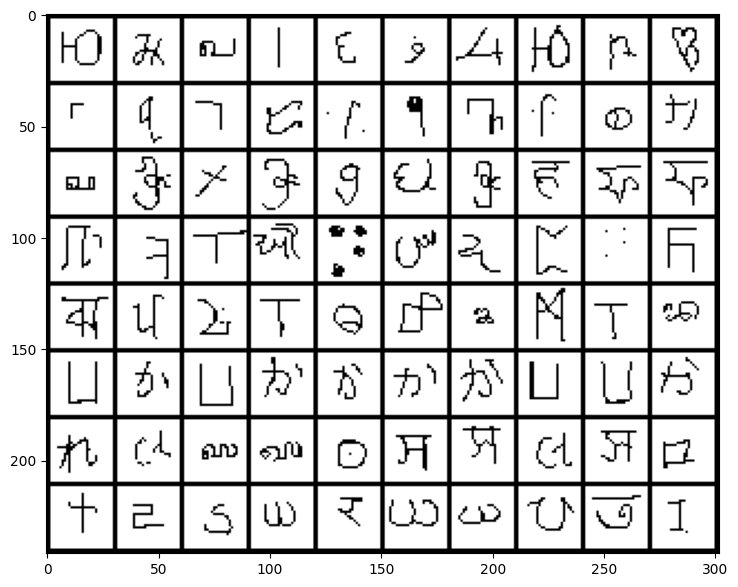

In [ ]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [ ]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64)
        )

    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)

### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [ ]:
def euclidean_dist(x, y):
    # x: (nq, d); y: (ns, d) -> output: (nq, ns)
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

In [ ]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim))
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images'].to(DEVICE)
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        x_dim = sample_images.size(-3)

        support = sample_images[:, :n_support, :, :, :].contiguous().view(n_way * n_support, x_dim, 28, 28)
        query = sample_images[:, n_support:, :, :, :].contiguous().view(n_way * n_query, x_dim, 28, 28)

        z_support = self.encoder(support)
        z_query = self.encoder(query)

        z_proto = z_support.view(n_way, n_support, -1).mean(1)

        dists = euclidean_dist(z_query, z_proto)
        log_p_y = F.log_softmax(-dists, dim=1)
        y_query = torch.arange(n_way).unsqueeze(1).expand(n_way, n_query).reshape(-1).to(DEVICE)

        loss_val = F.nll_loss(log_p_y, y_query)
        acc_val = (log_p_y.argmax(dim=1) == y_query).float().mean()
        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': log_p_y.argmax(dim=1)
        }

In [ ]:
def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = Encoder()
    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [ ]:
pip install wandb

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mikisevam (mikisevam-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## версия train с dual-логированием

In [ ]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop

    train_loss_history = []
    train_acc_history = []

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc=f"Epoch {epoch+1} train"):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size

        # ручное логирование
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # wandb логирование
        wandb.log({
            "loss": epoch_loss,
            "accuracy": epoch_acc,
            "epoch": epoch + 1
        })

        print(f"Epoch {epoch+1} -- Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        epoch += 1
        scheduler.step()

    return train_loss_history, train_acc_history

In [ ]:
wandb.init(project="protonet-omniglot", name="proto-run")

In [ ]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

In [ ]:
os.makedirs("models", exist_ok=True)

In [ ]:
%%time

train_loss, train_acc = train(
    model, optimizer, train_x, train_y,
    n_way=60, n_support=5, n_query=5,
    max_epoch=5, epoch_size=2000
)

torch.save(model.state_dict(), save_path+"models/protonet_model.pt")

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_acc)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("report/plots.png")
plt.show()

## Test

In [ ]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']

    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [ ]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

## Test on specific example

In [ ]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)

In [ ]:
print(f"Shape: {my_sample['images'].shape} — (n_way, n_support+n_query, C, H, W)")
print(f"n_way = {n_way}, n_support = {n_support}, n_query = {n_query}")
display_sample(my_sample['images'])

In [ ]:
loss, output = model.set_forward_loss(my_sample)
print(f"Predicted labels: {output['y_hat'].cpu().numpy()}")

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [ ]:
def predict_and_visualize(model, test_x, test_y, n_way=5, n_support=5, n_query=1, save_path1=save_path+"predictions/sample_predictions.txt"):
    os.makedirs("predictions", exist_ok=True)
    lines = []

    for idx in range(10):  # 10 эпизодов
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        images = sample['images']
        display_sample(images)

        loss, output = model.set_forward_loss(sample)
        preds = output['y_hat'].cpu().numpy()
        true = np.tile(np.arange(n_way), n_query)

        print(f"Episode {idx}:")
        lines.append(f"[Episode {idx}]")
        for i in range(n_way * n_query):
            print(f"  Image {i}: predicted = {preds[i]}, true = {true[i]}")
            lines.append(f"  Predicted: {preds[i]} | Reference: {true[i]}")
        lines.append("")

    with open(save_path1, "w") as f:
        f.write("\n".join(lines))

    print(f"Predictions saved to {save_path1}")

In [ ]:
predict_and_visualize(model, testx, testy, n_way=5, n_support=5, n_query=1)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды:
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара



In [ ]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

clf_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=simclr_transform)
cifar_clf = datasets.CIFAR10(root='./data', train=True, download=False, transform=clf_transform)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=clf_transform)

train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True)
clf_loader = DataLoader(cifar_clf, batch_size=128, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=128, shuffle=False)

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hid_dim=512, out_dim=128):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )

    def forward(self, x):
        return F.normalize(self.proj(x), dim=1)

class SimCLRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.resnet18(pretrained=False)
        self.encoder.fc = nn.Identity()
        self.projector = ProjectionHead(in_dim=512)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return projections

In [ ]:
#можно не тут
simclr_model = SimCLRModel().to(DEVICE)

# Замораживаем энкодер
for p in simclr_model.encoder.parameters():
    p.requires_grad = False
#можно не тут



# Добавляем классификатор
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            h = self.encoder(x)
        out = self.classifier(h)
        return out

In [ ]:
def train_classifier(model, loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        print(f"Epoch {epoch+1}: Loss {total_loss/len(loader):.4f}, Accuracy {correct/total:.4f}")

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [ ]:
# Модель с предобученным SimCLR (предположим, ты обучила simclr_model)
frozen_encoder = simclr_model.encoder
for p in frozen_encoder.parameters():
    p.requires_grad = False

clf_simclr = DownstreamClassifier(frozen_encoder).to(DEVICE)
train_classifier(clf_simclr, clf_loader)

# Модель без SimCLR (рандомный ResNet)
fresh_encoder = models.resnet18(pretrained=False)
fresh_encoder.fc = nn.Identity()

clf_random = DownstreamClassifier(fresh_encoder).to(DEVICE)
train_classifier(clf_random, clf_loader)